In [1]:
!pip -q install umap-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import types
from torchvision.models.resnet import Bottleneck
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


### Part 1

In [2]:
trainTransform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

valTransform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])
trainDataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=trainTransform)
valDataset   = datasets.CIFAR10(root="./data", train=False, download=True, transform=valTransform)

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valLoader   = DataLoader(valDataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# loading pretrained resNet-152
weights = models.ResNet152_Weights.IMAGENET1K_V2
model = models.resnet152(weights=weights)

# Last FC layer for CIFAR-10
inFeatures = model.fc.in_features
model.fc = nn.Linear(inFeatures, 10)

# Freeze everything else and train only last FC layer
for name, p in model.named_parameters():
    p.requires_grad = (name.startswith("fc."))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

100%|██████████| 170M/170M [00:02<00:00, 80.1MB/s]


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:03<00:00, 76.4MB/s]
/tmp/ipython-input-4061034922.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [3]:
def runEpoch(model, loader, train: bool):
    model.train(train)
    totalLoss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, leave=False)
    for x, y in pbar:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        totalLoss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

        pbar.set_postfix(loss=totalLoss/total, acc=correct/total)

    return totalLoss/total, correct/total

for epoch in range(1, 6):
    trainLoss, trainAcc = runEpoch(model, trainLoader, train=True)
    vaLoss, vaAcc = runEpoch(model, valLoader, train=False)
    print(f"Epoch {epoch}: train acc={trainAcc:.4f} val acc={vaAcc:.4f}")


  0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-932468402.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 1: train acc=0.7848 val acc=0.8303


Epoch 2: train acc=0.8346 val acc=0.8470


Epoch 3: train acc=0.8467 val acc=0.8447


Epoch 4: train acc=0.8507 val acc=0.8512


Epoch 5: train acc=0.8549 val acc=0.8477


### Part 2

In [5]:
# Task 2 (did two experiments):
# A) layer4+head fine-tune, skips ON
# B) layer4+head fine-tune, skips OFF (selected blocks)

def make_no_skip_forward(block: Bottleneck):
    def forward_no_skip(self, x):
        out = self.conv1(x); out = self.bn1(out); out = self.relu(out)
        out = self.conv2(out); out = self.bn2(out); out = self.relu(out)
        out = self.conv3(out); out = self.bn3(out)
        if self.downsample is not None:
            _ = self.downsample(x)

        out = self.relu(out)
        return out
    return forward_no_skip

def disable_skips_in_blocks(resnet, layer_block_pairs):
    for layer_name, idx in layer_block_pairs:
        layer = getattr(resnet, layer_name)
        blk = layer[idx]
        if not isinstance(blk, Bottleneck):
            raise TypeError(f"{layer_name}[{idx}] is not a Bottleneck block")
        blk.forward = types.MethodType(make_no_skip_forward(blk), blk)
    return resnet

# train only layer4 + fc
def build_model(skips_off=False, no_skip_blocks=None):
    weights = models.ResNet152_Weights.IMAGENET1K_V2
    model = models.resnet152(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, 10)

    if skips_off:
        if no_skip_blocks is None:
            no_skip_blocks = [("layer3", 0), ("layer4", 0)]  # choose a few blocks
        model = disable_skips_in_blocks(model, no_skip_blocks)

    # freeze all
    for p in model.parameters():
        p.requires_grad = False

    # unfreeze layer4 + fc
    for p in model.layer4.parameters():
        p.requires_grad = True
    for p in model.fc.parameters():
        p.requires_grad = True

    model = model.to(device)

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    return model, trainable_params

def train_model(name, model, trainable_params, train_loader, val_loader, epochs=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    def run_epoch(loader, train: bool):
        model.train(train)
        total_loss, correct, total = 0.0, 0, 0

        for x, y in tqdm(loader, leave=False):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            total_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        return total_loss/total, correct/total

    history = []
    print(f"\n=== {name} (lr={lr}) ===")
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(train_loader, train=True)
        va_loss, va_acc = run_epoch(val_loader, train=False)
        history.append((tr_loss, tr_acc, va_loss, va_acc))
        print(f"Epoch {ep}: train acc={tr_acc:.4f} val acc={va_acc:.4f}")
    return history

NO_SKIP_BLOCKS = [("layer3", 0), ("layer3", 2), ("layer4", 0)]  # adjust as needed

# a) skips ON
model_on, params_on = build_model(skips_off=False)
hist_on = train_model("A) layer4+head fine-tune — skips ON", model_on, params_on, trainLoader, valLoader, epochs=5, lr=1e-4)

# b) skips OFF
model_off, params_off = build_model(skips_off=True, no_skip_blocks=NO_SKIP_BLOCKS)
hist_off = train_model("B) layer4+head fine-tune — skips OFF", model_off, params_off, trainLoader, valLoader, epochs=5, lr=1e-4)


/tmp/ipython-input-3438499415.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))



=== A) layer4+head fine-tune — skips ON (lr=0.0001) ===


  0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-3438499415.py:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 1: train acc=0.8381 val acc=0.9023


Epoch 2: train acc=0.9163 val acc=0.9160


Epoch 3: train acc=0.9437 val acc=0.9154


Epoch 4: train acc=0.9635 val acc=0.9167


Epoch 5: train acc=0.9741 val acc=0.9232

=== B) layer4+head fine-tune — skips OFF (lr=0.0001) ===


Epoch 1: train acc=0.1633 val acc=0.2454


Epoch 2: train acc=0.2808 val acc=0.3045


Epoch 3: train acc=0.3341 val acc=0.3471


Epoch 4: train acc=0.3633 val acc=0.3753


Epoch 5: train acc=0.3869 val acc=0.3828


### Part c

In [ ]:
#task3Collect features from early/middle/late layers + t-SNE or UMAP

In [6]:
import numpy as np
def getFeatureExtractor(model):
    model.eval()
    feats = {"early": [], "mid": [], "late": []}
    labels = []

    def hook_factory(key):
        def hook(module, inp, out):
            pooled = out.mean(dim=(2,3)).detach().cpu()
            feats[key].append(pooled)
        return hook

    h1 = model.layer1.register_forward_hook(hook_factory("early"))
    h3 = model.layer3.register_forward_hook(hook_factory("mid"))
    h4 = model.layer4.register_forward_hook(hook_factory("late"))

    return feats, labels, (h1, h3, h4)

@torch.no_grad()
def collectFeatures(model, loader, max_batches=40):
    feats, labels, hooks = getFeatureExtractor(model)

    for i, (x, y) in enumerate(tqdm(loader, total=max_batches)):
        if i >= max_batches:
            break
        x = x.to(device, non_blocking=True)
        _ = model(x)
        labels.append(y)

    for h in hooks:
        h.remove()
    y = torch.cat(labels).numpy()
    out = {}
    for k in feats:
        out[k] = torch.cat(feats[k]).numpy()
    return out, y

features, y = collectFeatures(model, valLoader, max_batches=30)  # ~30*128 ≈ 3840 samples
{ k: v.shape for k,v in features.items() }, y.shape


100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


({'early': (3840, 256), 'mid': (3840, 1024), 'late': (3840, 2048)}, (3840,))

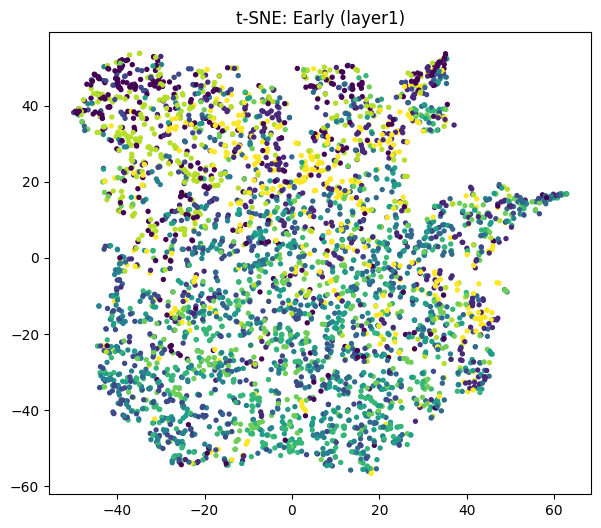

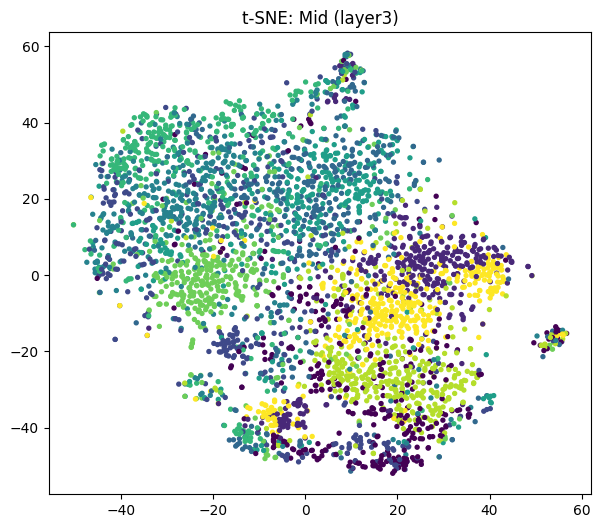

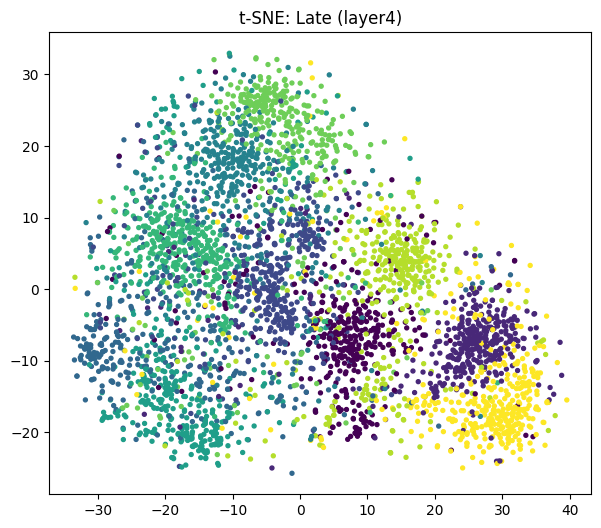

In [7]:
def tsnePlot(X, y, title):
    X2 = TSNE(n_components=2, perplexity=30, init="pca", learning_rate="auto").fit_transform(X)
    plt.figure(figsize=(7,6))
    plt.scatter(X2[:,0], X2[:,1], c=y, s=8)
    plt.title(title)
    plt.show()

tsnePlot(features["early"], y, "t-SNE: Early (layer1)")
tsnePlot(features["mid"], y, "t-SNE: Mid (layer3)")
tsnePlot(features["late"], y, "t-SNE: Late (layer4)")


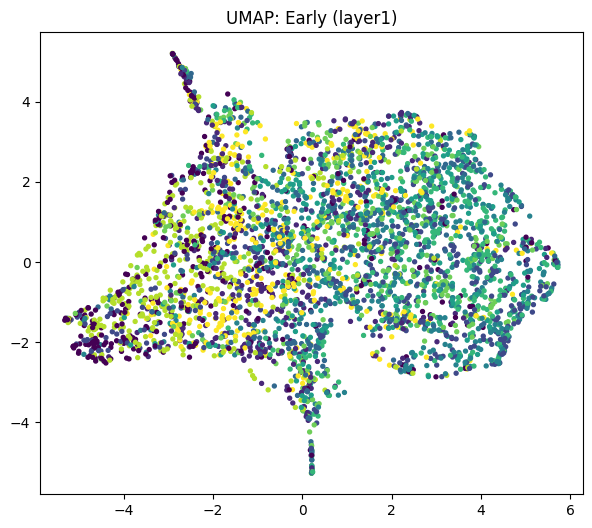

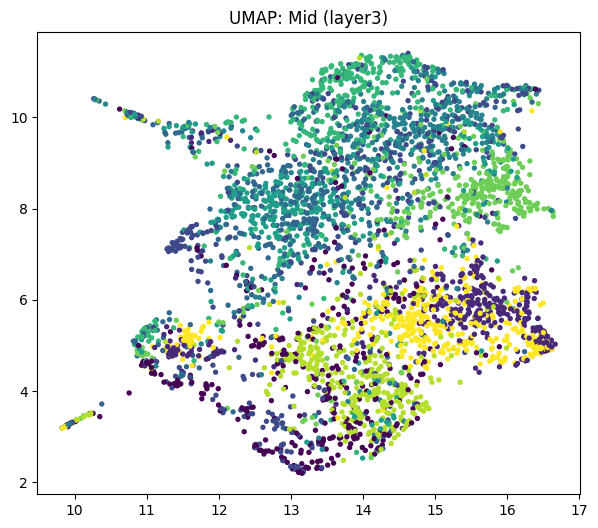

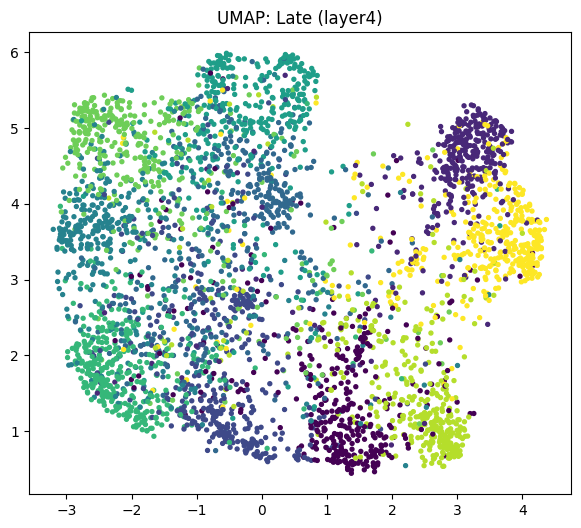

In [8]:
def umapPlot(X, y, title):
    X2 = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1).fit_transform(X)
    plt.figure(figsize=(7,6))
    plt.scatter(X2[:,0], X2[:,1], c=y, s=8)
    plt.title(title)
    plt.show()

umapPlot(features["early"], y, "UMAP: Early (layer1)")
umapPlot(features["mid"], y, "UMAP: Mid (layer3)")
umapPlot(features["late"], y, "UMAP: Late (layer4)")


### Part 4

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def setTrainable(model, mode):
    for p in model.parameters():
        p.requires_grad = False

    for p in model.fc.parameters():
        p.requires_grad = True

    if mode == "head":
        return

    if mode == "last_block":
        for p in model.layer4.parameters():
            p.requires_grad = True
        return

    if mode == "full":
        for p in model.parameters():
            p.requires_grad = True
        return


def buildResnet152(num_classes=10, init="imagenet", train_mode="last_block"):
    if init == "imagenet":
        weights = models.ResNet152_Weights.IMAGENET1K_V2
        model = models.resnet152(weights=weights)
    elif init == "random":
        model = models.resnet152(weights=None)

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    setTrainable(model, train_mode)
    model = model.to(device)

    trainableParams = [p for p in model.parameters() if p.requires_grad]
    return model, trainableParams

def trainEval1(model, trainable_params, train_loader, val_loader, epochs=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    def runEpoch(loader, train: bool):
        model.train(train)
        total_loss, correct, total = 0.0, 0, 0
        print("reeeee")
        for x, y in tqdm(loader, leave=False):
            print("what")
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            total_loss += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += x.size(0)
        return total_loss/total, correct/total

    hist = []
    print("reached")
    for ep in range(1, epochs+1):
        trLoss, trAcc = runEpoch(trainLoader, train=True)
        #vaLoss, vaAcc = runEpoch(valLoader, train=False)
        #hist.append((trLoss, trAcc, vaLoss, vaAcc))
        print(f"Epoch {ep}: train acc={trAcc:.4f} train loss={trLoss:.4f}")

        #print(f"Epoch {ep}: train acc={trAcc:.4f} val acc={vaAcc:.4f}")
        #print(f"Epoch {ep}: train loss={trLoss:.4f} val loss={vaLoss:.4f}")

    return hist

def trainEval(model, trainable_params, train_loader, val_loader, epochs=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    def runEpoch(loader, train: bool):
        model.train(train)
        total_loss, correct, total = 0.0, 0, 0
        for x, y in tqdm(loader, leave=False):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += x.size(0)
        return total_loss/total, correct/total

    for ep in range(1, epochs+1):
        trLoss, trAcc = runEpoch(train_loader, train=True)
        print(f"Epoch {ep}: train acc={trAcc:.4f} train loss={trLoss:.4f}")


# b) ImageNet pretrained, fine-tune only final block (layer4) + head
# model_A, params_A = build_resnet152(init="imagenet", train_mode="last_block")
# hist_A = train_eval(model_A, params_A, train_loader, val_loader, epochs=5, lr=1e-4)

In [4]:
# # B) ImageNet pretrained, fine-tune full backbone
# # model_B, params_B = build_resnet152(init="imagenet", train_mode="full")
# # hist_B = train_eval(model_B, params_B, train_loader, val_loader, epochs=5, lr=1e-5)  # usually lower LR
# def train_model_accum(
#     name, model, trainable_params, train_loader, val_loader,
#     epochs=5, lr=1e-5, accum_steps=4
# ):


#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=1e-4)
#     scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

#     def runEpoch(loader, train: bool):
#         model.train(train)
#         total_loss, correct, total = 0.0, 0, 0

#         optimizer.zero_grad(set_to_none=True)

#         for step, (x, y) in enumerate(tqdm(loader, leave=False), start=1):
#             x = x.to(device, non_blocking=True)
#             y = y.to(device, non_blocking=True)

#             with torch.cuda.amp.autocast(enabled=(device=="cuda")):
#                 logits = model(x)
#                 loss = criterion(logits, y)
#                 if train:
#                     loss = loss / accum_steps

#             if train:
#                 scaler.scale(loss).backward()
#                 if step % accum_steps == 0:
#                     scaler.step(optimizer)
#                     scaler.update()
#                     optimizer.zero_grad(set_to_none=True)

#             # metrics use the unscaled loss
#             total_loss += (loss.item() * accum_steps) * x.size(0)
#             pred = logits.argmax(dim=1)
#             correct += (pred == y).sum().item()
#             total += x.size(0)

#         # handle leftover grads if len(loader) not divisible by accum_steps
#         if train and (step % accum_steps != 0):
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad(set_to_none=True)

#         return total_loss/total, correct/total

#     print(f"\n=== {name} | lr={lr} | accum_steps={accum_steps} ===")
#     hist = []
#     for ep in range(1, epochs+1):
#         trainLoss, trainAcc = runEpoch(train_loader, train=True)
#         valLoss, valAcc = runEpoch(val_loader, train=False)
#         hist.append((trainLoss, trainAcc, valLoss, valAcc))
#         print(f"Epoch {ep}: train acc={tr_acc:.4f} val acc={va_acc:.4f}")
#     return hist



In [19]:
trainLoader.num_workers

2

In [18]:
# c) Random init to train full backbone
modelC, paramsC = buildResnet152(init="random", train_mode="full")
hist_C = trainEval(modelC, paramsC, trainLoader, valLoader, epochs=3, lr=1e-3)

/tmp/ipython-input-3622053827.py:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


Randomizing weights
eval


  0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipython-input-3622053827.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


KeyboardInterrupt: 

In [13]:
print("len(trainLoader):", len(trainLoader))


len(trainLoader): 782
